## Preprocessing audio data sample for DL





In [3]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Text(0.5, 1.0, 'Waveform')

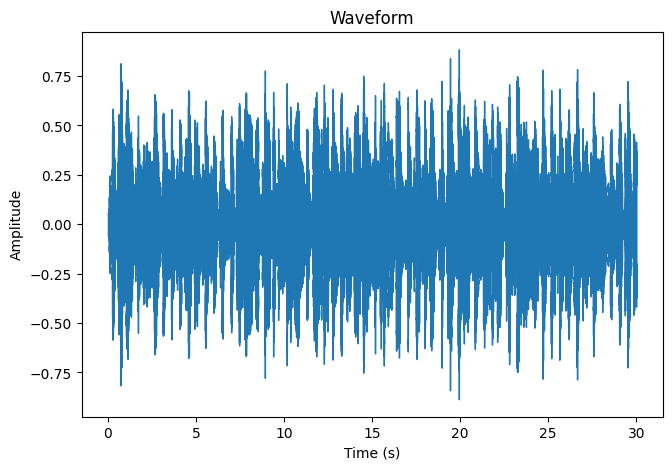

In [4]:
FIG_SIZE = (7.5,5)

file = "/content/drive/MyDrive/Colab Notebooks/AI-2024/Data/genres_original/blues/blues.00000.wav"

# load audio file usig Librosa
signal, sample_rate = librosa.load(file, sr=22050)

# Show waveform
plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(signal, sr=sample_rate)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

Text(0.5, 1.0, 'Power spectrum')

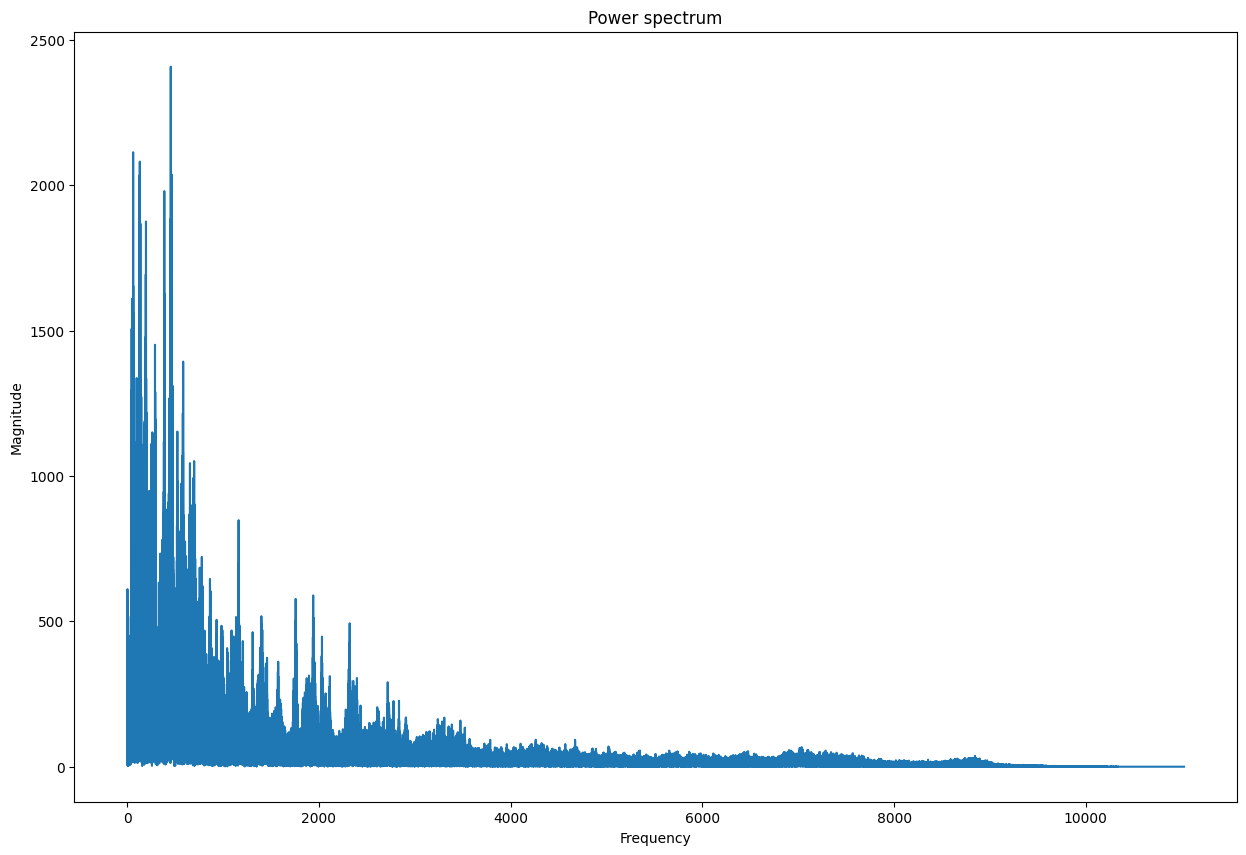

In [ ]:
# Fourier transform
fft = np.fft.fft(signal)

magnitude = np.abs(fft)
frequency = np.linspace(0, sample_rate, len(magnitude))

left_magnitude = magnitude[:int(len(magnitude)/2)]
left_frequency = frequency[:int(len(frequency)/2)]

# plot spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")

Text(0.5, 1.0, 'Spectrogram')

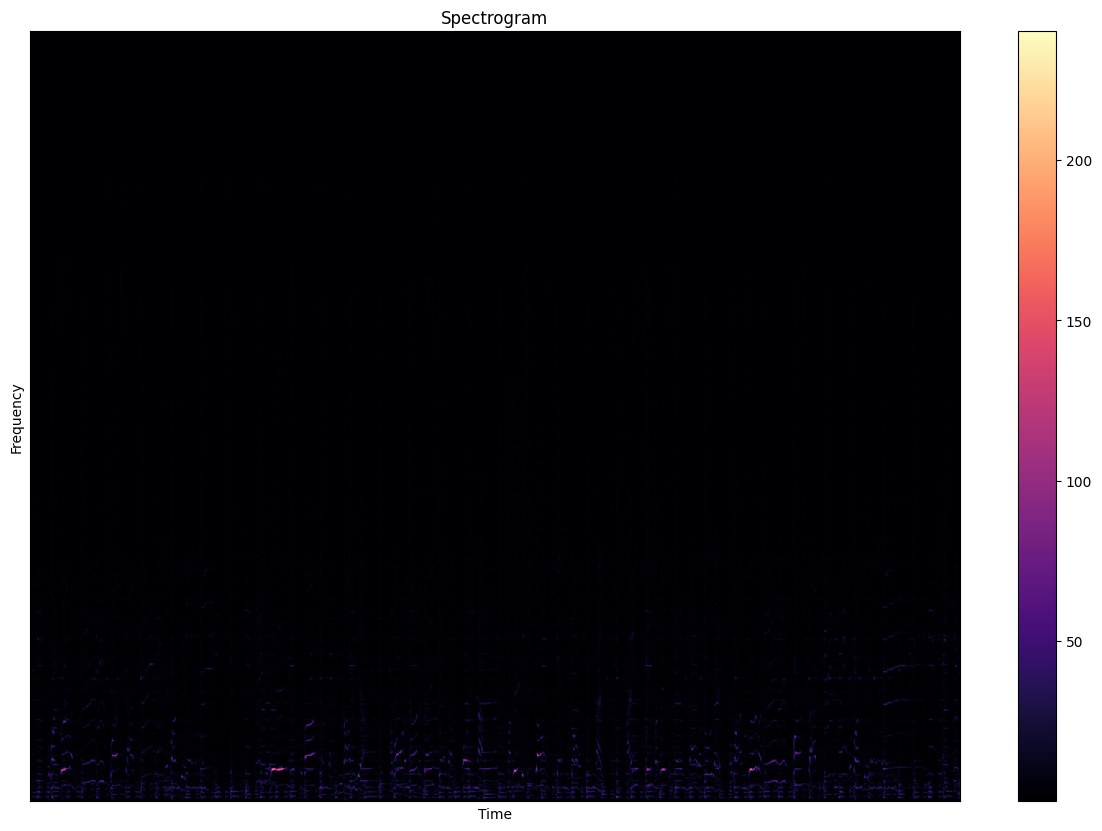

In [ ]:
# STFT Spectrogram
n_fft = 2048
hop_length = 512

# perform stft
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

spectrogram = np.abs(stft)

# display spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

In [ ]:
log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

Output hidden; open in https://colab.research.google.com to view.

Text(0.5, 1.0, 'MFCCs')

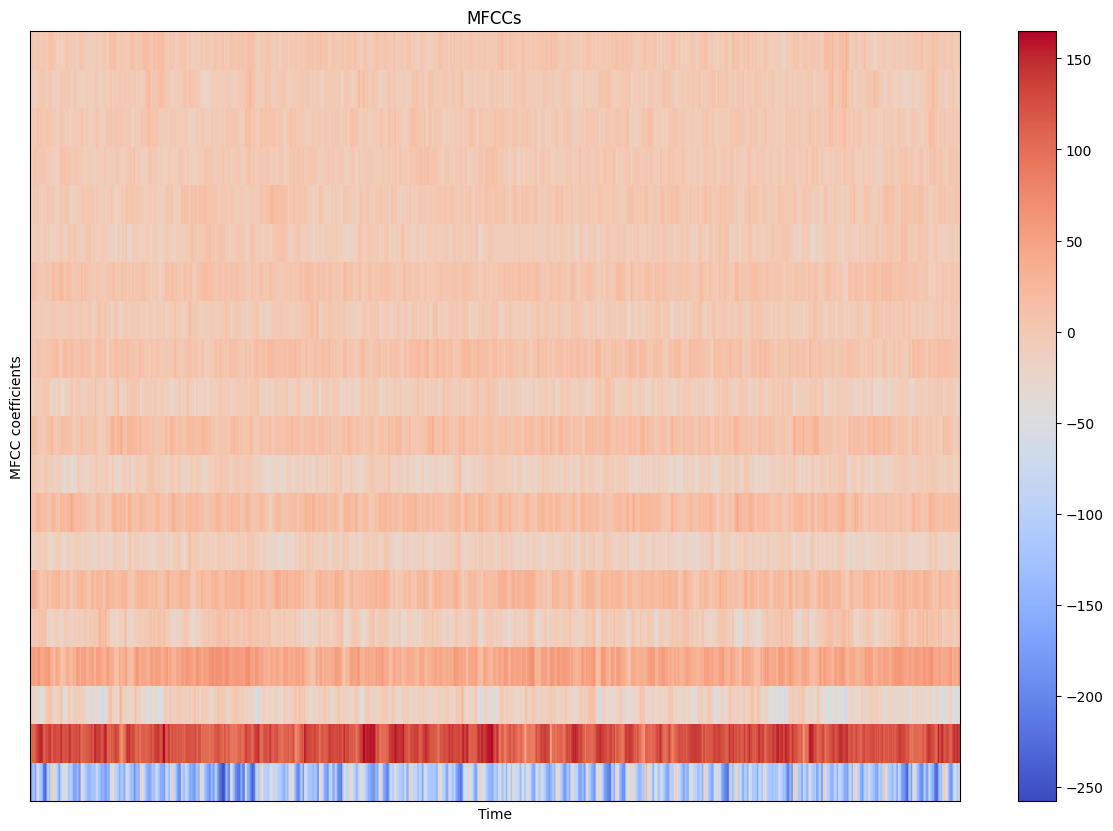

In [ ]:
# MFCCs

MFCCs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=20)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

## Music genre classification: Preparing the dataset

In [ ]:
import json
import os
import math
import librosa

DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/AI-2024/Data/genres_original"
JSON_PATH = os.path.join("/content/drive/MyDrive/Colab Notebooks/AI-2024/Data", "data.json")
SAMPLE_RATE = 22050
TRACK_DURATION = 30  # in secs
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
# Extracts MFCCs and saves them into a json file along with genre labels
def get_mfcc_dictionary(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):

    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            genre_label = dirpath.split("/")[-1]
            data["mapping"].append(genre_label)
            print("\nProcessing: {}".format(genre_label))

            # process all audio files in genre sub-dir
            for f in filenames:

                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(
                        y=signal[start:finish],
                        sr=sample_rate,
                        n_mfcc=num_mfcc,
                        n_fft=n_fft,
                        hop_length=hop_length
                    )
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i - 1)

    return data


In [ ]:
def dump_to_json(data, json_path):
    print("\nDumping data to file:", json_path)
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)


In [ ]:
# Generate data
data = get_mfcc_dictionary(DATASET_PATH, JSON_PATH, num_segments=10)



Processing: reggae

Processing: metal

Processing: rock

Processing: blues

Processing: country

Processing: jazz

Processing: pop

Processing: disco

Processing: classical

Processing: hiphop


In [ ]:
dump_to_json(data, JSON_PATH)


Dumping data to file: /content/drive/MyDrive/Colab Notebooks/AI-2024/Data/data.json


## Music genre classification: Implementing a Neural Network

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [ ]:
def load_data(data_path):

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")


    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.5)

    plt.show()

In [ ]:
X, y = load_data(JSON_PATH)

# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = keras.Sequential([


        # input layer
        keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

        # 1st dense layer
        keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        # 2nd dense layer
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        # 3rd dense layer
        keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        # output layer
        keras.layers.Dense(10, activation='softmax')
])

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)


Data succesfully loaded!
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 1690)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               865792    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 64)                16448     
                                                                 
 dropout_5 (Dropout)         

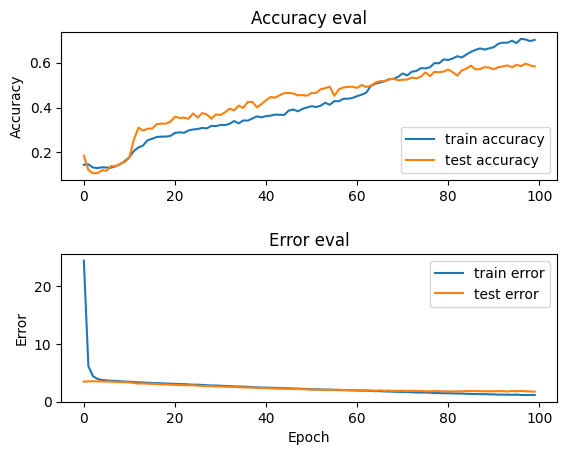

In [ ]:
plot_history(history)

## Music genre classification: Implementing a CNN

In [ ]:
def prepare_datasets(test_size, validation_size):
    X, y = load_data(JSON_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


In [ ]:

def build_model(input_shape):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model




In [ ]:
def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [ ]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)




Data succesfully loaded!
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 6, 32)         0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 64, 6, 32)         128       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 2, 32)         0         
 g2D)                                                            
                             

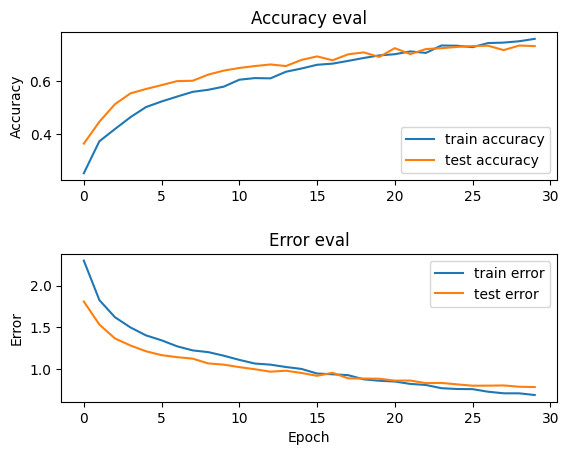

In [ ]:
plot_history(history)

In [ ]:

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

# predict sample
predict(model, X_to_predict, y_to_predict)

79/79 - 1s - loss: 0.8154 - accuracy: 0.7131 - 779ms/epoch - 10ms/step

Test accuracy: 0.7130852341651917
1/1 [==============================] - 0s 18ms/step
Target: 2, Predicted label: [4]


## GitHub Commit

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/AI-2024/Music-Genre-Classification


/content/drive/MyDrive/Colab Notebooks/AI-2024/Music-Genre-Classification


In [ ]:
!git status

On branch master
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Music-Genre-Classification.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:

!git config --global user.name "AyaSafan"
!git config --global user.email "ayasafan16@gmail.com"

!git add .
!git commit -m "build CNN"
!git push origin master


[master aaf7963] build CNN
 1 file changed, 1 insertion(+), 1 deletion(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 41.24 KiB | 1.21 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/AyaSafan/Music-Genre-Classification.git
   58489b9..aaf7963  master -> master
